<div style="background-color: #633ca1; color: #ffffff; padding: 10px; text-align: center;">
    CAMADA BRONZE
</div>


<div style="background-color: #2bc2a0; color: #ffffff; padding: 10px; text-align: center;">
    API Kaggle - baixar arquivos CSV
</div>


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_date, when, concat, lit
from delta.tables import DeltaTable
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tempfile
import subprocess
import sys

In [0]:
# Kaggle
json_file_path = 'dbfs:/FileStore/KaggleToken/kaggle.json'
spark_json_df = spark.read.format('json').option('header', 'true').option('inferschema', 'true').load(json_file_path)
username = spark_json_df.select(spark_json_df.username).take(1)[0]['username']
key= spark_json_df.select(spark_json_df.key).take(1)[0]['key']

# Definir o nome do dataset do Kaggle
kaggle_dataset_name = "dillonmyrick/bike-store-sample-database"
path = "dbfs:/FileStore/Datum/Data/csv"

In [0]:
def kaggle_auth(username, key):
    from kaggle.api.kaggle_api_extended import KaggleApi
    os.environ["KAGGLE_USERNAME"] = username
    os.environ["KAGGLE_KEY"] = key
    
    api = KaggleApi()
    api.authenticate()

    print("Autenticação realizada com successo!")

    return api

In [0]:
try:
    api = kaggle_auth(username, key)
except Exception as e:
    print(e)
    print("Instalando módulos do Kaggle...")

    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])
    api = kaggle_auth(username, key)

Autenticação realizada com successo!


In [0]:
del spark_json_df

In [0]:
def obter_informacoes_dataset(api, nome_completo_dataset):
    try:
        datasets = api.dataset_list(search=nome_completo_dataset)
        for dataset in datasets:
            if dataset.ref == nome_completo_dataset:
                return dataset
        print(f"Dataset {nome_completo_dataset} não encontrado.")
        return None
    except Exception as e:
        print(f"Erro ao recuperar informações do dataset: {e}")
        return None
    
def baixar_e_salvar_dataset(api, nome_dataset, caminho_dbfs):
    with tempfile.TemporaryDirectory() as tmpdir:
        api.dataset_download_files(nome_dataset, path=tmpdir, unzip=True)

        arquivos = os.listdir(tmpdir)
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(tmpdir, arquivo)
            caminho_destino = os.path.join(caminho_dbfs, arquivo)
            dbutils.fs.cp(f"file:{caminho_arquivo}", caminho_destino)
            print(f"* Arquivo {arquivo} salvo em {caminho_destino}")

def download(api, nome_dataset, caminho_dbfs):
    dataset = obter_informacoes_dataset(api, nome_dataset)

    if dataset:
        print(
            f"--> Iniciando download dos arquivos do DataSet {kaggle_dataset_name}..."
        )
        baixar_e_salvar_dataset(api, nome_dataset, caminho_dbfs)
    else:
        print("--> Não foi possível obter as informações do dataset.")

In [0]:
# verificar_atualizacao_e_download(api, KAGGLE_DATASET_NAME, DBFS_DEST_PATH, PREVIOUS_UPDATE)
download(api, kaggle_dataset_name, path)

--> Iniciando download dos arquivos do DataSet dillonmyrick/bike-store-sample-database...
Dataset URL: https://www.kaggle.com/datasets/dillonmyrick/bike-store-sample-database
* Arquivo orders.csv salvo em dbfs:/FileStore/Datum/Data/csv/orders.csv
* Arquivo stocks.csv salvo em dbfs:/FileStore/Datum/Data/csv/stocks.csv
* Arquivo products.csv salvo em dbfs:/FileStore/Datum/Data/csv/products.csv
* Arquivo order_items.csv salvo em dbfs:/FileStore/Datum/Data/csv/order_items.csv
* Arquivo staffs.csv salvo em dbfs:/FileStore/Datum/Data/csv/staffs.csv
* Arquivo customers.csv salvo em dbfs:/FileStore/Datum/Data/csv/customers.csv
* Arquivo categories.csv salvo em dbfs:/FileStore/Datum/Data/csv/categories.csv
* Arquivo stores.csv salvo em dbfs:/FileStore/Datum/Data/csv/stores.csv
* Arquivo brands.csv salvo em dbfs:/FileStore/Datum/Data/csv/brands.csv


In [0]:
# Função para calcular e exibir valores nulos
def mostrar_resumo_valores_nulos(df, table_name):
    """
    Exibe o resumo dos valores nulos para cada coluna de um DataFrame.

    Args:
    df (DataFrame): DataFrame a ser analisado.
    table_name (str): Nome da tabela associada ao DataFrame.
    """
    null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    print(f"Resumo dos valores nulos para o DataFrame '{table_name}':")
    null_counts_dict = null_counts.first().asDict()
    for column, null_count in null_counts_dict.items():
        print(f"{column}: {null_count}")

# Função para mostrar info do df
def mostrar_informacoes_esquema(df, table_name):
    """
    Exibe informações sobre o esquema de um DataFrame.
    Esta função imprime o esquema de um DataFrame, incluindo os nomes das colunas e os tipos de dados correspondentes.
    Args:
    df (DataFrame): O DataFrame para o qual as informações de esquema serão exibidas.
    table_name (str): O nome associado ao DataFrame, usado para identificação na saída.

    Returns:
    None
        Esta função não retorna nada; ela apenas imprime as informações do esquema.

    Exemplo:
    >>> mostrar_informacoes_esquema(df, "orders")
    Informações sobre o DataFrame 'orders':
    root
    |-- column1: integer (nullable = true)
    |-- column2: string (nullable = true)
    |-- ...
    |-- columnN: double (nullable = true)

    """
    print(f"Informações sobre o DataFrame '{table_name}':")
    df.printSchema()

# Função para verificar valores duplicados
def verificar_duplicados(df, table_name, columns=None):
    """
    Verifica se há valores duplicados em um DataFrame do PySpark.

    Args:
    df (DataFrame): DataFrame do PySpark a ser verificado.
    table_name (str): Nome da tabela.
    columns (list): Lista opcional de colunas para verificar duplicatas. Se não especificado, todas as colunas serão verificadas.

    Returns:
    bool: True se existem duplicatas, False caso contrário.

    """
    if columns is None:
        # Verificar duplicatas em todas as colunas
        num_duplicates = df.count() - df.distinct().count()
    else:
        # Verificar duplicatas apenas nas colunas especificadas
        num_duplicates = df.select(columns).count() - df.select(columns).distinct().count()

    if num_duplicates > 0:
        print(f"Foram encontradas e removidas {num_duplicates} linhas duplicadas no DataFrame.")
        return True
    else:
        print(f"Não foram encontradas linhas duplicadas no DataFrame.{table_name}")
        return False

# Função para remover valores duplicados
def remover_valores_duplicados(df, columns=None):
    """
    Remove valores duplicados de um DataFrame, mantendo apenas uma ocorrência de cada valor duplicado.

    Args:
    df (DataFrame): DataFrame a ser verificado.
    columns (list): Lista opcional de colunas para verificar duplicatas. Se não especificado, todas as colunas serão consideradas.

    Returns:
    DataFrame: DataFrame com valores duplicados removidos.

    """
    if columns is None:
        # Remover duplicatas em todas as colunas
        df = df.dropDuplicates()
    else:
        # Remover duplicatas apenas nas colunas especificadas
        df = df.dropDuplicates(subset=columns)
    
    return df

# Função para exportar DataFrame para Delta Lake
def exportar_para_delta_lake(df, table_name, camada):
    """
    Exporta um DataFrame para o Delta Lake.

    Args:
    df (DataFrame): DataFrame a ser exportado.
    table_name (str): Nome da tabela.
    camada (str): Camada para onde exportar os dados.
    """
    # Caminho para salvar os dados Delta
    caminho_salvar = f'dbfs:/FileStore/Datum/Data/delta/{camada}/{table_name}'
    # Salvar o DataFrame no formato Delta
    df.write.format("delta").mode("overwrite").option("path", caminho_salvar).save()

def exportar_para_parquet(df, file_name, camada):
    """
    Exporta um DataFrame para um arquivo Parquet.

    Args:
    df (DataFrame): DataFrame a ser exportado.
    file_name (str): Nome do arquivo Parquet.
    camada (str): Camada para onde exportar os dados.
    """
    # Caminho para salvar o arquivo Parquet
    caminho_salvar = f'dbfs:/FileStore/Datum/Data/parquet/{camada}/{file_name}'
    # Salvar o DataFrame como arquivo Parquet
    df.write.format("parquet").mode("overwrite").option("path", caminho_salvar).save()

In [0]:
# Lista de nomes dos arquivos CSV
arquivos_csv = ['brands', 'categories', 'customers', 'order_items', 'orders', 'products', 'staffs', 'stocks', 'stores']

In [0]:
#Spark session
spark = SparkSession.builder \
    .appName("BikeStore") \
    .getOrCreate()

In [0]:
# Dicionário para armazenar os DataFrames
dataframes = {}

# Iterar sobre os nomes dos arquivos CSV
for file in arquivos_csv:
    # Construir o caminho do arquivo CSV
    file_path = f'/FileStore/Datum/Data/csv/{file}.csv'
    # Ler o arquivo CSV e armazenar o DataFrame no dicionário
    dataframes[file] = spark.read.csv(file_path, header=True, inferSchema=True)
    # Atribuir cada DataFrame a uma variável separada
    globals()[f"{file}_df"] = dataframes[file]

# Exibir os DataFrames carregados
for file, df in dataframes.items():
    print(f"DataFrame '{file}':")
    df.limit(10).show()

DataFrame 'brands':
+--------+------------+
|brand_id|  brand_name|
+--------+------------+
|       1|     Electra|
|       2|        Haro|
|       3|      Heller|
|       4| Pure Cycles|
|       5|     Ritchey|
|       6|     Strider|
|       7|Sun Bicycles|
|       8|       Surly|
|       9|        Trek|
+--------+------------+

DataFrame 'categories':
+-----------+-------------------+
|category_id|      category_name|
+-----------+-------------------+
|          1|  Children Bicycles|
|          2|   Comfort Bicycles|
|          3|  Cruisers Bicycles|
|          4|Cyclocross Bicycles|
|          5|     Electric Bikes|
|          6|     Mountain Bikes|
|          7|         Road Bikes|
+-----------+-------------------+

DataFrame 'customers':
+-----------+----------+---------+--------------+--------------------+--------------------+---------------+-----+--------+
|customer_id|first_name|last_name|         phone|               email|              street|           city|state|zip_code|

In [0]:
# Exportar para Delta Lake na camada bronze
for table_name, df in dataframes.items():
    exportar_para_delta_lake(df, table_name, 'bronze')
    exportar_para_parquet(df, f'{table_name}.parquet', 'bronze')

<div style="text-align:center;">
    <img src="https://i.imgur.com/04YEup6.png" alt="Schema Bike Store">
</div>


<div style="background-color: #633ca1; color: #ffffff; padding: 10px; text-align: center;">
    CAMADA SILVER
</div>


<div style="background-color: #2bc2a0; color: #ffffff; padding: 10px; text-align: center;">
    Limpeza de Dados (Formatação de Colunas, Valores Ausentes, Valores Duplicados, Tipos de Dados)
</div>


In [0]:
# Substituir "NULL" por None
# Iterar sobre cada DataFrame
for table_name, df in dataframes.items():
    print(f"Conversão de valores 'NULL' para 'None' no DataFrame '{table_name}':")
    # Iterar sobre cada coluna do DataFrame
    for column in df.columns:
        # Substituir "NULL" por None na coluna atual
        df = df.withColumn(column, when(df[column] == "NULL", None).otherwise(df[column]))
    # Atualizar o DataFrame no dicionário
    dataframes[table_name] = df

Conversão de valores 'NULL' para 'None' no DataFrame 'brands':
Conversão de valores 'NULL' para 'None' no DataFrame 'categories':
Conversão de valores 'NULL' para 'None' no DataFrame 'customers':
Conversão de valores 'NULL' para 'None' no DataFrame 'order_items':
Conversão de valores 'NULL' para 'None' no DataFrame 'orders':
Conversão de valores 'NULL' para 'None' no DataFrame 'products':
Conversão de valores 'NULL' para 'None' no DataFrame 'staffs':
Conversão de valores 'NULL' para 'None' no DataFrame 'stocks':
Conversão de valores 'NULL' para 'None' no DataFrame 'stores':


In [0]:
# Iterar sobre cada DataFrame
for table_name, df in dataframes.items():
    # Exibir resumo dos valores nulos
    mostrar_resumo_valores_nulos(df, table_name)
    # Exibir informações do esquema
    mostrar_informacoes_esquema(df, table_name)

Resumo dos valores nulos para o DataFrame 'brands':
brand_id: 0
brand_name: 0
Informações sobre o DataFrame 'brands':
root
 |-- brand_id: integer (nullable = true)
 |-- brand_name: string (nullable = true)

Resumo dos valores nulos para o DataFrame 'categories':
category_id: 0
category_name: 0
Informações sobre o DataFrame 'categories':
root
 |-- category_id: integer (nullable = true)
 |-- category_name: string (nullable = true)

Resumo dos valores nulos para o DataFrame 'customers':
customer_id: 0
first_name: 0
last_name: 0
phone: 1267
email: 0
street: 0
city: 0
state: 0
zip_code: 0
Informações sobre o DataFrame 'customers':
root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- phone: string (nullable = true)
 |-- email: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: integer (nullable = true)

Resumo 

In [0]:
# Verificar e remover duplicatas em todos os DataFrames
for table_name, df in dataframes.items():
    if verificar_duplicados(df, table_name):
        dataframes[table_name] = remover_valores_duplicados(df)

Não foram encontradas linhas duplicadas no DataFrame.brands
Não foram encontradas linhas duplicadas no DataFrame.categories
Não foram encontradas linhas duplicadas no DataFrame.customers
Não foram encontradas linhas duplicadas no DataFrame.order_items
Não foram encontradas linhas duplicadas no DataFrame.orders
Não foram encontradas linhas duplicadas no DataFrame.products
Não foram encontradas linhas duplicadas no DataFrame.staffs
Não foram encontradas linhas duplicadas no DataFrame.stocks
Não foram encontradas linhas duplicadas no DataFrame.stores


In [0]:
# ORDERS - Convertendo o campo shipped_date para tipo Date
orders_df = orders_df.withColumn("shipped_date", to_date(orders_df["shipped_date"], "yyyy-MM-dd"))

# STAFFS - Convertendo o campo manager_id de string para integer
staffs_df = staffs_df.withColumn("manager_id", staffs_df["manager_id"].cast("integer"))

# STAFFS - Criando a coluna full_name
staffs_df = staffs_df.withColumn("full_name", concat(col("first_name"), lit(' '), col("last_name")))

# CUSTOMERS - Criando a coluna full_name
customers_df = customers_df.withColumn("full_name", concat(col("first_name"), lit(' '), col("last_name")))

# CUSTOMERS - Converter a coluna 'zip_code' para string
customers_df = customers_df.withColumn("zip_code", col("zip_code").cast("string"))

# STORES - Converter a coluna 'zip_code' para string
stores_df = stores_df.withColumn("zip_code", col("zip_code").cast("string"))

# Atualizar DataFrame no dicionário após aplicar as transformações
dataframes["orders"] = orders_df
dataframes["staffs"] = staffs_df
dataframes["customers"] = customers_df
dataframes["stores"] = stores_df

# Verificando o DataFrame e Esquemas atualizado
# Orders
orders_df.show()
mostrar_informacoes_esquema(orders_df, "orders")

# Staffs
staffs_df.show()
mostrar_informacoes_esquema(staffs_df, "staffs")

# Customers
customers_df.show()
mostrar_informacoes_esquema(customers_df, "customers")

# Stores
stores_df.show()
mostrar_informacoes_esquema(stores_df, "stores")

+--------+-----------+------------+----------+-------------+------------+--------+--------+
|order_id|customer_id|order_status|order_date|required_date|shipped_date|store_id|staff_id|
+--------+-----------+------------+----------+-------------+------------+--------+--------+
|       1|        259|           4|2016-01-01|   2016-01-03|  2016-01-03|       1|       2|
|       2|       1212|           4|2016-01-01|   2016-01-04|  2016-01-03|       2|       6|
|       3|        523|           4|2016-01-02|   2016-01-05|  2016-01-03|       2|       7|
|       4|        175|           4|2016-01-03|   2016-01-04|  2016-01-05|       1|       3|
|       5|       1324|           4|2016-01-03|   2016-01-06|  2016-01-06|       2|       6|
|       6|         94|           4|2016-01-04|   2016-01-07|  2016-01-05|       2|       6|
|       7|        324|           4|2016-01-04|   2016-01-07|  2016-01-05|       2|       6|
|       8|       1204|           4|2016-01-04|   2016-01-05|  2016-01-05|       

<div style="background-color: #2bc2a0; color: #ffffff; padding: 10px; text-align: center;">
    Exportações
</div>


In [0]:
%sql
-- Criar database
CREATE DATABASE IF NOT EXISTS BikeStore;
USE BikeStore;

In [0]:
for table_name, df in dataframes.items():
    # Exportar para Delta Lake
    delta_path = f'dbfs:/FileStore/Datum/Data/delta/silver/{table_name}'
    df.write.format("delta").mode("overwrite").save(delta_path)
    
    # Exportar para Parquet
    parquet_path = f'dbfs:/FileStore/Datum/Data/parquet/silver/{table_name}.parquet'
    df.write.format("parquet").mode("overwrite").save(parquet_path)
    
    # Nome completo da tabela no banco de dados BikeStore
    full_table_name = f"BikeStore.{table_name}"
    
    # Tratar a exceção caso a tabela não exista
    try:
        # Truncar os dados da tabela SQL existente
        spark.sql(f"TRUNCATE TABLE {full_table_name}")
    except:
        pass  # Se houver uma exceção (ou seja, a tabela não existe), ignore
    
    # Criar ou substituir a tabela permanente no banco de dados BikeStore
    df.write.format("delta").mode("overwrite").saveAsTable(full_table_name)
    
    # Carregar os dados da tabela Delta para a tabela SQL
    df_delta = spark.read.format("delta").load(delta_path)
    df_delta.write.format("delta").mode("append").saveAsTable(full_table_name)

<div style="background-color: #633ca1; color: #ffffff; padding: 10px; text-align: center;">
    CAMADA GOLD
</div>


<div style="background-color: #2bc2a0; color: #ffffff; padding: 10px; text-align: center;">
    Análise de dados
</div>


In [0]:
# Consulta SQL
query = '''
        with total_revenue AS
             (SELECT oi.order_id,  
                     ot.store_id,
                     s.store_name,
                     ot.order_date, 
                     oi.product_id,
                     oi.quantity, 
                     oi.list_price, 
                     oi.discount, 
                    ((oi.quantity * oi.list_price) * (1-oi.discount)) AS total_sale_product
              FROM order_items as oi
              LEFT JOIN orders as ot
              ON oi.order_id = ot.order_id 
              LEFT JOIN stores as s
              ON ot.store_id = s.store_id) 
              
              
        SELECT store_name, 
               SUM(total_sale_product) as revenue,
               ROUND((SUM(total_sale_product) / ((SELECT SUM(total_sale_product) FROM total_revenue))*100),2) as percentage
        FROM total_revenue
        GROUP BY store_name
        ORDER BY revenue DESC
        '''

# Executar a consulta e obter o ;DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+----------------+--------------------+----------+
|      store_name|             revenue|percentage|
+----------------+--------------------+----------+
|   Baldwin Bikes| 4.172601022000102E7|     67.83|
|Santa Cruz Bikes|1.2846584292000053E7|     20.88|
|   Rowlett Bikes|   6940337.948799976|     11.28|
+----------------+--------------------+----------+



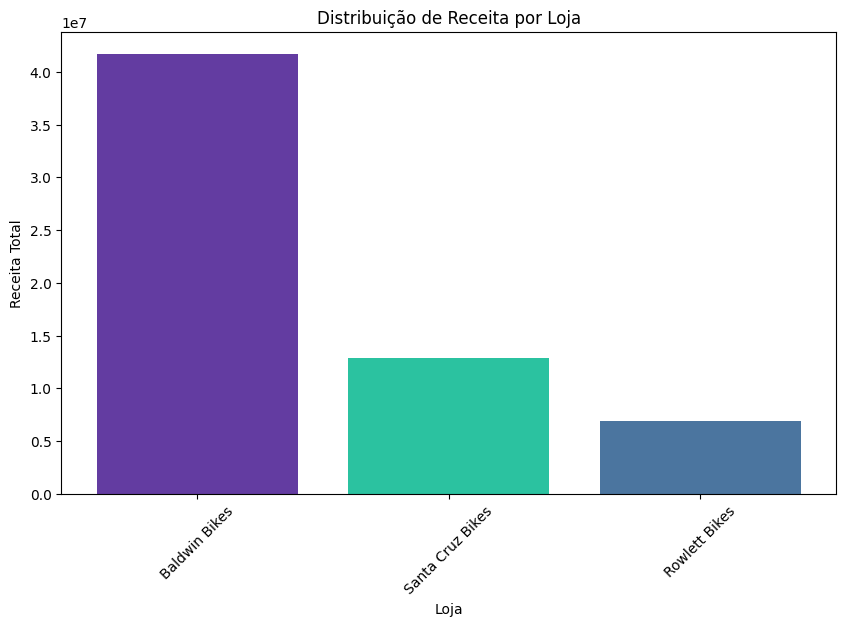

In [0]:
# Extrair os nomes das lojas e as receitas do DataFrame
store_names = df.select("store_name").rdd.flatMap(lambda x: x).collect()
revenues = df.select("revenue").rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(store_names, revenues, color=['#633ca1', '#2bc2a0', '#4b759f', '#43286c'])
plt.xlabel('Loja')
plt.ylabel('Receita Total')
plt.title('Distribuição de Receita por Loja')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.show()

In [0]:
# Consulta SQL
query = '''
        with total_spent AS
             (SELECT oi.order_id,
                     ot.customer_id,
                     c.full_name,
                     ot.order_date, 
                     oi.product_id,
                     oi.quantity, 
                     oi.list_price, 
                     oi.discount, 
                     ((oi.quantity * oi.list_price) * (1-oi.discount)) AS total_sale_product
              FROM order_items as oi
              LEFT JOIN orders as ot
              ON oi.order_id = ot.order_id
              LEFT JOIN customers as c
              ON ot.customer_id = c.customer_id) 
              
              
        SELECT customer_id, full_name, ROUND(SUM(total_sale_product),2) AS total_spent
        FROM total_spent
        GROUP BY customer_id, full_name
        ORDER BY total_spent DESC
        LIMIT 10 
        '''

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+-----------+---------------+-----------+
|customer_id|      full_name|total_spent|
+-----------+---------------+-----------+
|         94| Sharyn Hopkins|  278463.51|
|         10| Pamelia Newman|  269074.08|
|         75|    Abby Gamble|  262424.05|
|          6|   Lyndsey Bean|  261400.58|
|         16| Emmitt Sanchez|  255407.09|
|         73|  Melanie Hayes|  255309.52|
|          1|    Debra Burks|  223105.47|
|         61|Elinore Aguilar|  205091.62|
|         93| Corrina Sawyer|  204901.62|
|        122|   Shena Carter|   199125.0|
+-----------+---------------+-----------+



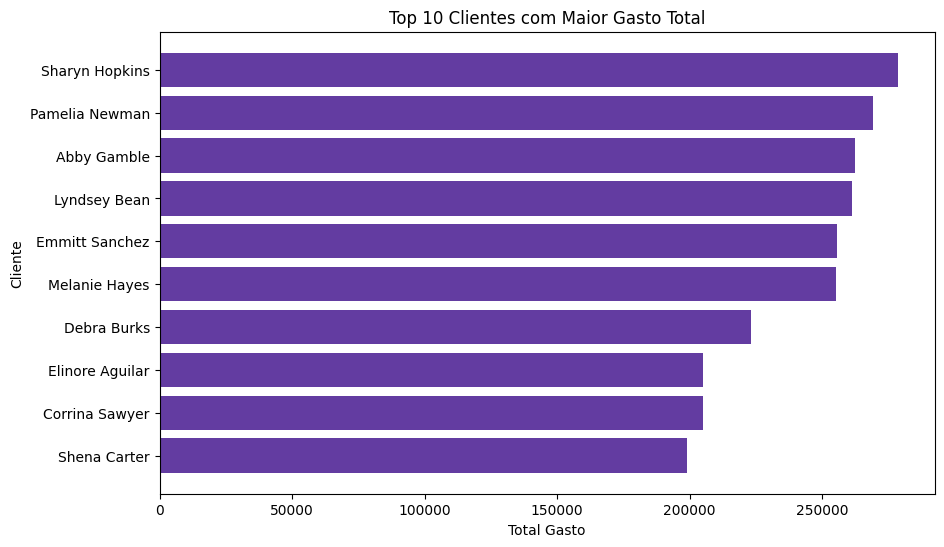

In [0]:
# Extrair os dados do DataFrame
customer_names = df.select('full_name').rdd.flatMap(lambda x: x).collect()
total_spent = df.select('total_spent').rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(customer_names, total_spent, color='#633ca1')
plt.xlabel('Total Gasto')
plt.ylabel('Cliente')
plt.title('Top 10 Clientes com Maior Gasto Total')
plt.gca().invert_yaxis()  # Inverter a ordem dos clientes para exibir o maior gasto no topo
plt.show()

In [0]:
# Consulta SQL - ANO
query = '''
WITH total_sale AS (
                    SELECT ot.order_date, 
                           oi.product_id,
                           oi.quantity, 
                           oi.list_price, 
                           oi.discount, 
                           ((oi.quantity * oi.list_price) * (1 - oi.discount)) AS total_sale_product
                    FROM order_items AS oi
                    LEFT JOIN orders AS ot ON oi.order_id = ot.order_id
)

SELECT date_format(order_date, 'yyyy') AS year,
       ROUND(SUM(total_sale_product), 2) AS total_revenue
       
FROM total_sale
GROUP BY year
ORDER BY total_revenue DESC
'''

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+----+-------------+
|year|total_revenue|
+----+-------------+
|2017|1.378883297E7|
|2016|   9709514.11|
|2018|   7258119.15|
+----+-------------+



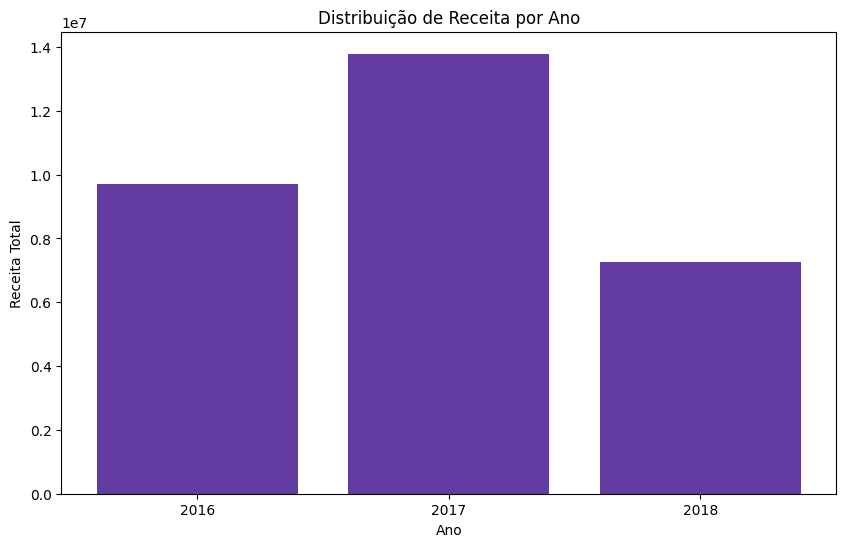

In [0]:
# Extrair os dados do DataFrame
years = df.select('year').rdd.flatMap(lambda x: x).collect()
revenues = df.select('total_revenue').rdd.flatMap(lambda x: x).collect()

# Ordenar os dados por ano
sorted_years, sorted_revenues = zip(*sorted(zip(years, revenues)))

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(sorted_years, sorted_revenues, color=['#633ca1'])
plt.xlabel('Ano')
plt.ylabel('Receita Total')
plt.title('Distribuição de Receita por Ano')
plt.show()

In [0]:
# Consulta SQL - MÊS
query = '''
WITH total_sale AS (
                    SELECT ot.order_date, 
                           oi.product_id,
                           oi.quantity, 
                           oi.list_price, 
                           oi.discount, 
                           ((oi.quantity * oi.list_price) * (1 - oi.discount)) AS total_sale_product
                    FROM order_items AS oi
                    LEFT JOIN orders AS ot ON oi.order_id = ot.order_id
)

SELECT date_format(order_date, 'MM') AS month,
       ROUND(SUM(total_sale_product), 2) AS total_revenue
       
FROM total_sale
GROUP BY month
ORDER BY total_revenue DESC
'''

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+-----+-------------+
|month|total_revenue|
+-----+-------------+
|   04|    4849427.3|
|   01|   3528772.03|
|   03|    3414012.9|
|   02|   2678776.53|
|   06|   2358467.08|
|   09|   2301843.32|
|   10|   2104750.07|
|   08|   2098354.59|
|   11|   1901077.29|
|   05|   1894012.99|
|   12|   1863411.72|
|   07|   1763560.43|
+-----+-------------+



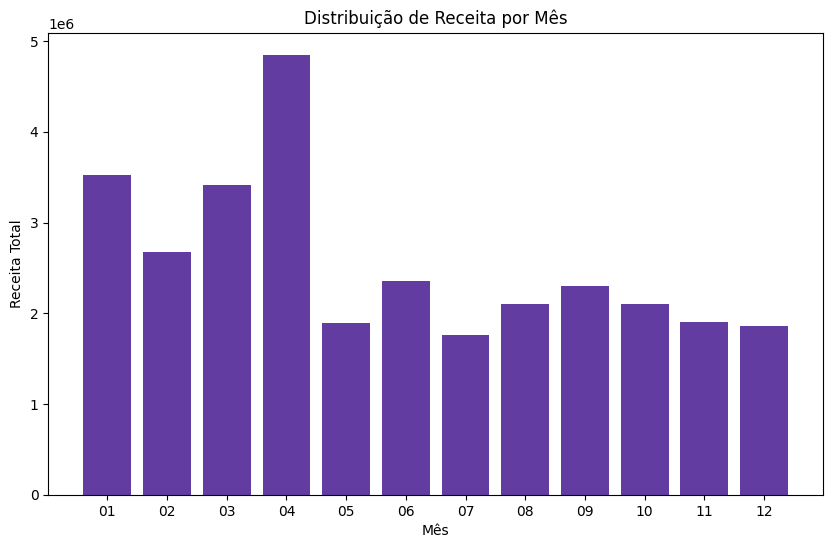

In [0]:
# Extrair os dados do DataFrame
months = df.select('month').rdd.flatMap(lambda x: x).collect()
revenues = df.select('total_revenue').rdd.flatMap(lambda x: x).collect()

# Ordenar os dados por mês
sorted_months, sorted_revenues = zip(*sorted(zip(months, revenues)))

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(sorted_months, sorted_revenues, color=['#633ca1'])
plt.xlabel('Mês')
plt.ylabel('Receita Total')
plt.title('Distribuição de Receita por Mês')
plt.show()

In [0]:
# Consulta SQL - MÊS/ANO
query = '''
WITH total_sale AS (
    SELECT ot.order_date, 
           oi.product_id,
           oi.quantity, 
           oi.list_price, 
           oi.discount, 
           ((oi.quantity * oi.list_price) * (1 - oi.discount)) AS total_sale_product
    FROM order_items AS oi
    LEFT JOIN orders AS ot ON oi.order_id = ot.order_id
)
SELECT date_format(order_date, 'yyyyMM') AS year_month,
       ROUND(SUM(total_sale_product), 2) AS total_revenue
FROM total_sale
GROUP BY year_month
ORDER BY year_month DESC
LIMIT 12

'''

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+----------+-------------+
|year_month|total_revenue|
+----------+-------------+
|    201812|     26067.87|
|    201811|     45448.03|
|    201810|     15124.51|
|    201809|     35855.86|
|    201808|     33511.26|
|    201807|      45351.6|
|    201806|       755.96|
|    201804|   3271687.44|
|    201803|   1455963.97|
|    201802|    802632.25|
|    201801|    1525720.4|
|    201712|   1038023.94|
+----------+-------------+



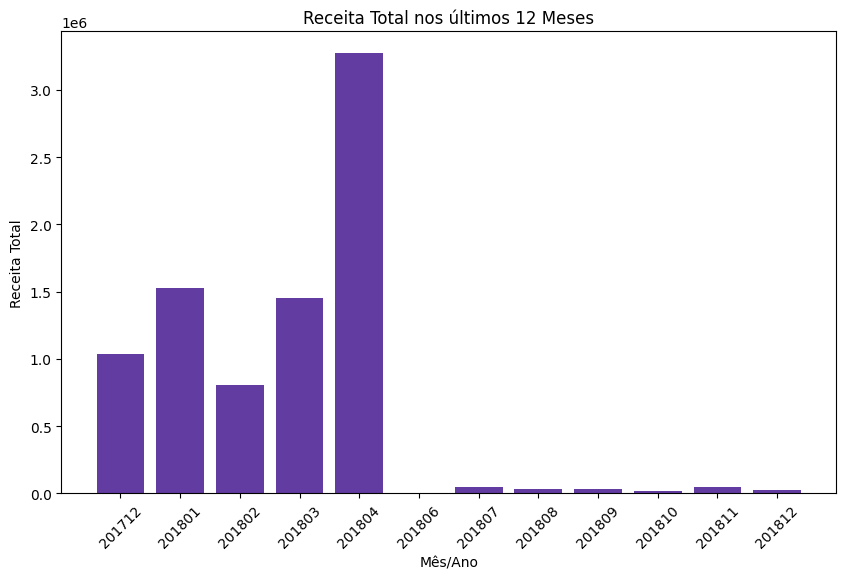

In [0]:
# Extrair os dados do DataFrame
year_month = df.select('year_month').rdd.flatMap(lambda x: x).collect()
revenues = df.select('total_revenue').rdd.flatMap(lambda x: x).collect()

# Ordenar os dados por mês/ano
sorted_data = sorted(zip(year_month, revenues), key=lambda x: int(x[0]))
sorted_months, sorted_revenues = zip(*sorted_data)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(sorted_months, sorted_revenues, color=['#633ca1'])
plt.xlabel('Mês/Ano')
plt.ylabel('Receita Total')
plt.title('Receita Total nos últimos 12 Meses')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.show()

In [0]:
# Consulta SQL
query = """
WITH total_sales AS (
                    SELECT ot.order_date,
                           oi.product_id,
                           p.product_name,
                           oi.quantity, 
                           oi.list_price, 
                           oi.discount, 
                           ((oi.quantity * oi.list_price) * (1 - oi.discount)) AS total_sale_product
                    FROM order_items AS oi
                    LEFT JOIN products AS p 
                    ON oi.product_id = p.product_id
                    LEFT JOIN orders as ot
                    ON oi.order_id = ot.order_id 
)


SELECT  product_name,
        SUM(quantity) AS quantity_sell ,
        ROUND(SUM(total_sale_product),2) AS total_revenue
FROM   total_sales
GROUP BY product_name
ORDER BY  total_revenue DESC
LIMIT 10
"""

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+--------------------+-------------+-------------+
|        product_name|quantity_sell|total_revenue|
+--------------------+-------------+-------------+
|Trek Slash 8 27.5...|         1232|   4444468.89|
|Trek Conduit+ - 2016|         1160|   3113989.62|
|Trek Fuel EX 8 29...|         1144|   2947781.84|
|Surly Straggler 6...|         1208|   1814124.41|
|Trek Domane SLR 6...|          344|   1692676.92|
|Surly Straggler -...|         1176|   1628060.96|
|Trek Remedy 29 Ca...|         1000|   1627046.96|
|Trek Powerfly 8 F...|          328|   1505996.99|
|Trek Madone 9.2 -...|          312|   1407197.19|
|Trek Silque SLR 8...|          232|   1396197.85|
+--------------------+-------------+-------------+



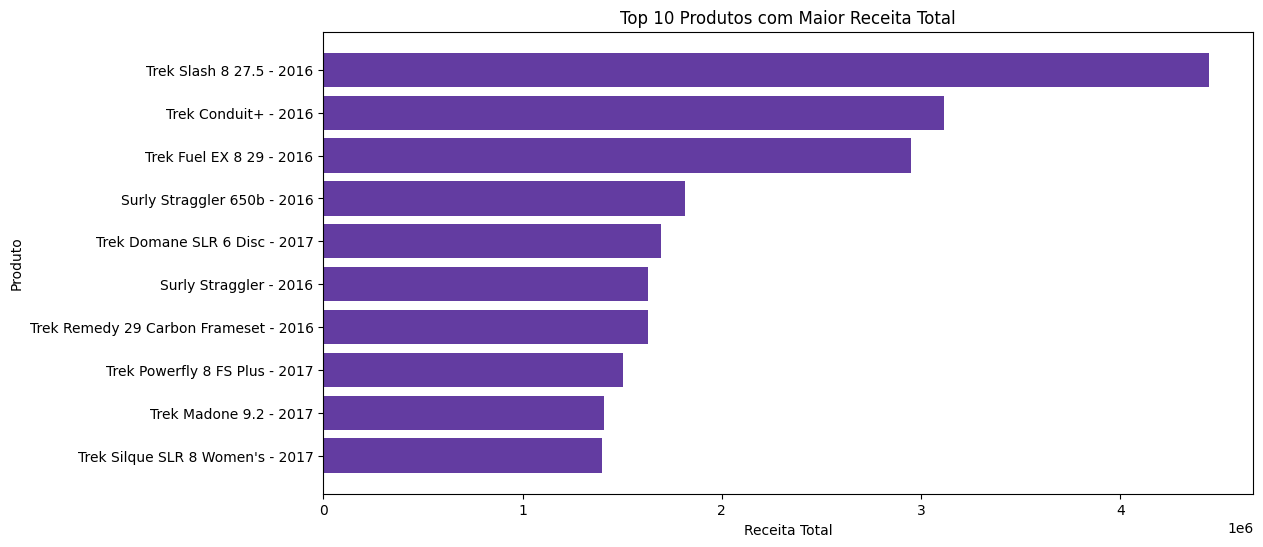

In [0]:
# Extrair os dados do DataFrame
products = df.select('product_name').rdd.flatMap(lambda x: x).collect()
quantities = df.select('quantity_sell').rdd.flatMap(lambda x: x).collect()
revenues = df.select('total_revenue').rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(products, revenues, color='#633ca1')
plt.xlabel('Receita Total')
plt.ylabel('Produto')
plt.title('Top 10 Produtos com Maior Receita Total')
plt.gca().invert_yaxis()  # Inverter a ordem dos produtos para exibir o maior no topo
plt.show()

In [0]:
# Consulta SQL
query = """
with subquery as (
                    SELECT oi.order_id,
                           oi.product_id,
                           oi.quantity,
                           oi.list_price,
                           oi.discount,
                           ROUND(((oi.quantity * oi.list_price) * (1 - oi.discount)),2) AS final_price,
                           s.staff_id,
                           s.full_name
                    FROM order_items as oi
                    FULL JOIN orders as ot
                    ON oi.order_id = ot.order_id
                    FULL JOIN staffs as s
                    ON ot.staff_id = s.staff_id)
                    
SELECT  staff_id,
        full_name,
        ROUND(SUM(final_price),2) as staff_revenue
FROM subquery
GROUP BY staff_id, full_name
ORDER BY staff_revenue DESC

"""

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+--------+------------------+-------------+
|staff_id|         full_name|staff_revenue|
+--------+------------------+-------------+
|       6|   Marcelene Boyer|  2.0992946E7|
|       7|     Venita Daniel|2.073302712E7|
|       3|     Genna Serrano|    6826292.4|
|       2|   Mireya Copeland|   6020280.08|
|       8|       Kali Vargas|   3711343.28|
|       9|     Layla Terrell|    3228988.8|
|      10|Bernardine Houston|         NULL|
|       1|   Fabiola Jackson|         NULL|
|       5|    Jannette David|         NULL|
|       4|    Virgie Wiggins|         NULL|
+--------+------------------+-------------+



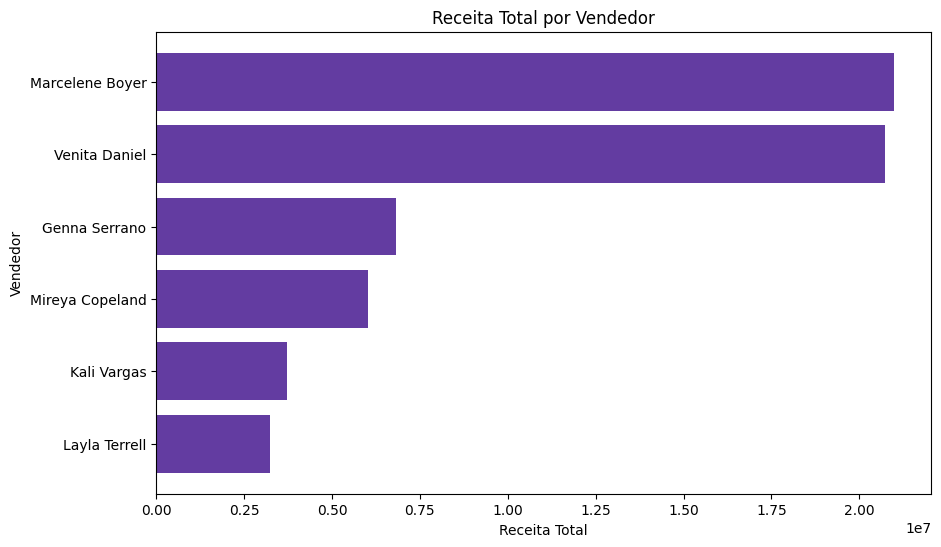

In [0]:
# Filtrar os dados para ignorar valores nulos
df_filtered = df.filter(df.staff_revenue.isNotNull())

# Extrair os dados do DataFrame filtrado
staff_names = df_filtered.select('full_name').rdd.flatMap(lambda x: x).collect()
revenues = df_filtered.select('staff_revenue').rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(staff_names, revenues, color='#633ca1')
plt.xlabel('Receita Total')
plt.ylabel('Vendedor')
plt.title('Receita Total por Vendedor')
plt.gca().invert_yaxis()  # Inverter a ordem dos membros da equipe para exibir o maior no topo
plt.show()

In [0]:
# Consulta SQL
query = """
WITH customer_stats AS (
    SELECT
        customer_id,
        SUM(quantity * list_price * (1 - discount)) AS total_spent,
        COUNT(DISTINCT orders.order_id) AS total_orders,
        DATEDIFF('2018-12-29', MAX(order_date)) AS days_since_last_purchase
    FROM
        orders
    INNER JOIN
        order_items
    ON
        orders.order_id = order_items.order_id
    GROUP BY
        customer_id
)

SELECT
    customer_id,
    CASE WHEN total_orders > 1 THEN 'frequente'
         ELSE 'ocasional'
         END AS frequencia,
    CASE WHEN days_since_last_purchase < 90 THEN 'recente'
         ELSE 'não recente'
         END AS recencia,
    CASE WHEN total_spent >= (SELECT PERCENTILE(total_spent, 0.75) FROM customer_stats) THEN 'grande gastador'
         WHEN total_spent <= (SELECT PERCENTILE(total_spent, 0.25) FROM customer_stats) THEN 'gastador econômico'
         ELSE 'gastador médio' 
         END AS valor
FROM
    customer_stats
"""

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+-----------+----------+-----------+------------------+
|customer_id|frequencia|   recencia|             valor|
+-----------+----------+-----------+------------------+
|        463| ocasional|não recente|   grande gastador|
|       1238| ocasional|não recente|   grande gastador|
|        833| ocasional|não recente|    gastador médio|
|       1342| ocasional|não recente|gastador econômico|
|        471| ocasional|não recente|gastador econômico|
|        148| ocasional|não recente|gastador econômico|
|        496| ocasional|não recente|   grande gastador|
|       1088| ocasional|não recente|    gastador médio|
|       1127| ocasional|não recente|    gastador médio|
|        623| ocasional|não recente|gastador econômico|
|       1084| ocasional|não recente|   grande gastador|
|        858| ocasional|não recente|    gastador médio|
|        392| ocasional|não recente|    gastador médio|
|       1025| ocasional|não recente|gastador econômico|
|        897| ocasional|não recente|gastador eco

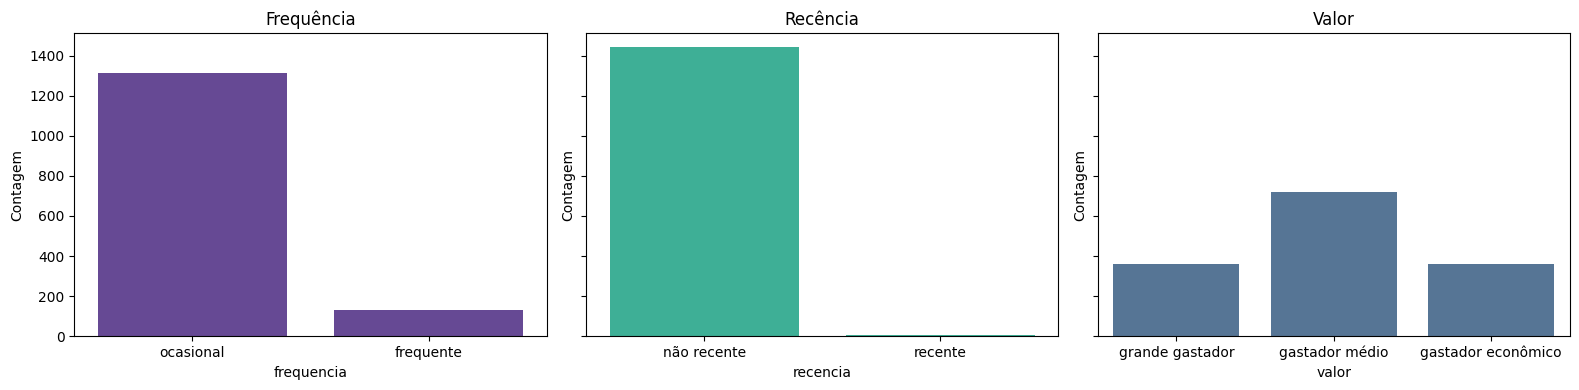

In [0]:
# Definir as cores personalizadas
cores = ['#633ca1', '#2bc2a0', '#4b759f']

# Converter DataFrame do Spark para DataFrame do pandas
df_pandas = df.toPandas()

# Criação do gráfico
fig, ax = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)

# Gráficos de contagem
for i, coluna in enumerate(['frequencia', 'recencia', 'valor']):
    sns.countplot(x=coluna, data=df_pandas, ax=ax[i], palette=[cores[i]])

# Títulos dos gráficos
ax[0].set_title('Frequência')
ax[1].set_title('Recência')
ax[2].set_title('Valor')

# Ajustes dos eixos
for axis in ax:
    axis.set_ylabel('Contagem')  # Adiciona rótulo ao eixo y

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [0]:
# Consulta SQL
query = """
WITH daily_orders AS (
    SELECT
        order_date,
        store_id,
        COUNT(*) AS orders
    FROM
        orders
    GROUP BY
        1,2
)

SELECT
    order_date,
    store_id,
    AVG(orders) OVER(PARTITION BY store_id 
                     ORDER BY order_date ASC
                     ROWS BETWEEN 14 PRECEDING AND 15 FOLLOWING) AS moving_avg_30d
FROM
    daily_orders;
"""

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+----------+--------+------------------+
|order_date|store_id|    moving_avg_30d|
+----------+--------+------------------+
|2016-01-01|       1|               2.5|
|2016-01-03|       1|2.4705882352941178|
|2016-01-05|       1|2.4444444444444446|
|2016-01-06|       1|2.4210526315789473|
|2016-01-09|       1|               2.4|
|2016-01-12|       1| 2.380952380952381|
|2016-01-14|       1|2.3636363636363638|
|2016-01-16|       1| 2.347826086956522|
|2016-01-21|       1|2.3333333333333335|
|2016-01-27|       1|              2.32|
|2016-02-03|       1|2.3076923076923075|
|2016-02-06|       1|2.2962962962962963|
|2016-02-07|       1| 2.357142857142857|
|2016-02-12|       1|2.3448275862068964|
|2016-02-16|       1|2.3333333333333335|
|2016-02-17|       1|2.3333333333333335|
|2016-02-19|       1|2.3333333333333335|
|2016-02-25|       1|2.3333333333333335|
|2016-02-26|       1|2.3333333333333335|
|2016-02-27|       1|2.3333333333333335|
+----------+--------+------------------+
only showing top

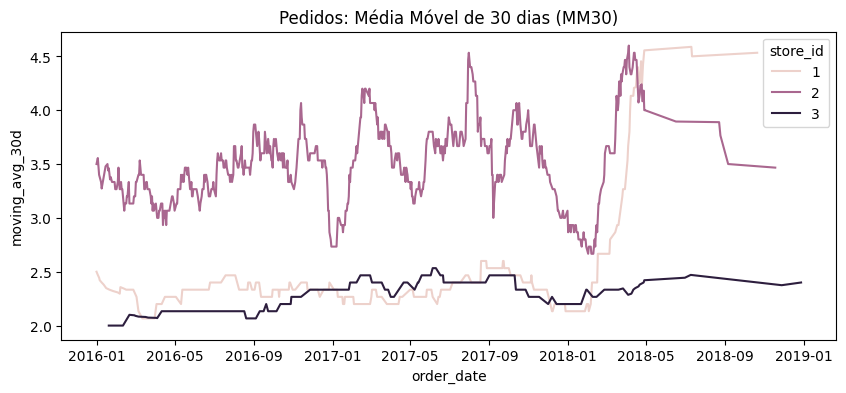

In [0]:
# Converter DataFrame do Spark para DataFrame do pandas
df_pandas = df.toPandas()

# Gráfico
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=df_pandas, x='order_date', y='moving_avg_30d', hue='store_id', ax=ax)
ax.set_title('Pedidos: Média Móvel de 30 dias (MM30)')
plt.show()

In [0]:
# Consulta SQL
query = """
WITH product_categories AS (
    SELECT
        product_id,
        category_name
    FROM
        products
    INNER JOIN
        categories
    ON
        products.category_id = categories.category_id
),

product_sales_ym AS (
    SELECT
        year(order_date) AS year,
        month(order_date) AS month,
        product_id,
        SUM(quantity) AS units_sold
    FROM
        orders
    INNER JOIN
        order_items
    ON
        orders.order_id = order_items.order_id
    GROUP BY
        1,2,3
)

SELECT
    month,
    category_name,
    AVG(units_sold) AS avg_units_sold
FROM
    product_sales_ym
INNER JOIN
    product_categories
ON
    product_sales_ym.product_id = product_categories.product_id
GROUP BY
    1,2;
"""

# Executar a consulta e obter o DataFrame resultante
df = spark.sql(query)

# Mostrar os resultados
df.show()

+-----+-------------------+------------------+
|month|      category_name|    avg_units_sold|
+-----+-------------------+------------------+
|    2|Cyclocross Bicycles|18.285714285714285|
|    7|  Children Bicycles|13.217391304347826|
|   10|  Children Bicycles|17.666666666666668|
|    5|  Cruisers Bicycles| 17.09090909090909|
|    3|  Cruisers Bicycles|12.842105263157896|
|    4|         Road Bikes| 9.019607843137255|
|   11|         Road Bikes|  9.23076923076923|
|    8|  Cruisers Bicycles|18.444444444444443|
|    4|   Comfort Bicycles|              11.7|
|    3|     Electric Bikes|               8.8|
|    2|  Children Bicycles|              12.6|
|    7|   Comfort Bicycles|              15.0|
|   10|Cyclocross Bicycles|              27.2|
|    5|  Children Bicycles|              12.2|
|    2|  Cruisers Bicycles|11.928571428571429|
|   11|     Electric Bikes|              28.0|
|    5|     Electric Bikes| 9.333333333333334|
|    6|  Children Bicycles|              14.0|
|    4|  Chil

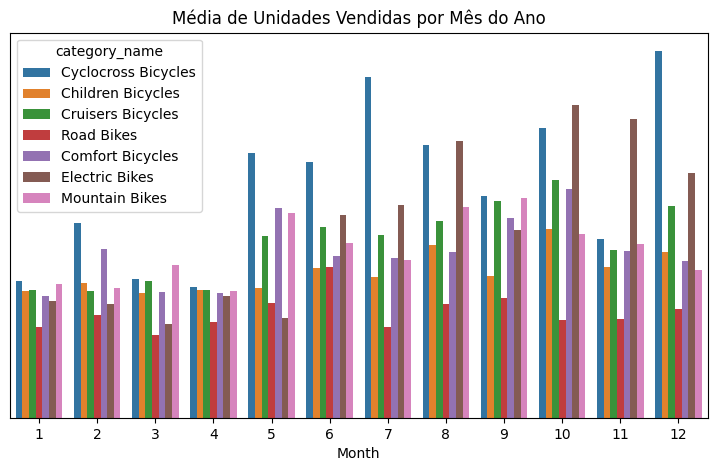

In [0]:
# Converter DataFrame do Spark para DataFrame do pandas
df_pandas = df.toPandas()

# Gráfico
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(data=df_pandas, x='month', y='avg_units_sold', hue='category_name', errorbar=None, ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('Month')
ax.set_title('Média de Unidades Vendidas por Mês do Ano')
plt.show()

In [0]:
# Encerrar a sessão Spark
spark.stop()

com.databricks.backend.common.rpc.SparkStoppedException: Spark down: 
	at com.databricks.backend.daemon.driver.DriverWrapper.executeCommandAndGetError(DriverWrapper.scala:675)
	at com.databricks.backend.daemon.driver.DriverWrapper.executeCommand(DriverWrapper.scala:712)
	at com.databricks.backend.daemon.driver.DriverWrapper.runInnerLoop(DriverWrapper.scala:538)
	at com.databricks.backend.daemon.driver.DriverWrapper.runInner(DriverWrapper.scala:464)
	at com.databricks.backend.daemon.driver.DriverWrapper.run(DriverWrapper.scala:290)
	at java.lang.Thread.run(Thread.java:750)